# AQI Data For Redmond, Oregon
---
The goal of this notebook is to gather historical Air Quality Index (AQI) data for Redmond, Oregon, which is located in Deschutes County from May 1st through October 31 from 1963 onwards.

Specifically, we use the US Environmental Protection Agency (EPA) Air Quality Service (AQS) API, which is a historical API and does not provide real-time air quality data. The [documentation](https://aqs.epa.gov/aqsweb/documents/data_api.html) for the API provides definitions of the different call parameter and examples of the various calls that can be made to the API. Additional information on the Air Quality System can be found in the [EPA FAQ](https://www.epa.gov/outdoor-air-quality-data/frequent-questions-about-airdata).

The Air Quality Index is a measure designed to tell us how healthy the air is on any given day and is commonly used to track pollutants such as smog or smoke. Generally, a rating of 0-50 indicates healthy, clean air, while 500 is the highest tracked value for hazardous air. A thorough explanation of how AQI is calculated can be found [here](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf).

Finding nearby monitoring stations requires the Federal Information Processing Series (FIPS)
of the desired city, county, and state. Information was gathered from [here](https://www.census.gov/library/reference/code-lists/ansi.html#cou). The FIPS values used in this notebook are as follows:
* State: 41
* County: 017

This format, the 5 digit string, is a 'old' format that is still widely used. 

## License

Note that a **majority** of the following code was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code was provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023.

Specifically, the following functions along with the initialization of the constants required for the APIs were written by Dr. McDonald:
* `request_signup()`
* `request_list_info()`
* `request_daily_summary()`

The rest of the code lies under the standard [MIT licence](./LICENSE).

## 0. Set-up
This notebooks assumes that the user has a working Jupyter Notebook Python 3 set-up. Instructions on installing them can be found [here](https://docs.jupyter.org/en/latest/install/notebook-classic.html).

Specifically, here are the following Python modules that we need for this work. Some are standard modules that come installed with Python and others should come installed as part of the [Anaconda](https://docs.jupyter.org/en/latest/install/notebook-classic.html) distribution. 

If modules are not found, they can be readily installed with the following terminal commands:

```bash
    pip install <module name>
```
or 
```bash
   conda install <module name>
```

In [13]:
# These are standard python modules
import json, copy, time

# The 'requests','tqdm', and 'pandas' modules are not standard python libraries
# You will need to install these with pip/pip3 if you do not already have it

# distribution module for making web requests
import requests
# a highly recommended progress bar for loops.
from tqdm.auto import tqdm, trange
# a recommended module to read and wrangle data
import pandas as pd
# recommended modules for visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Best for array manipulation
import numpy as np


### Constants

Here, we define the common endpoint of the AQS API and possible actions that can done with API.
We also set up a template to easily feed necessary information into the API request.

In [14]:
#   This is the root of all AQS API URLs
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#    These are 'actions' we can ask the API to take or requests that we can make of the API

#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'

#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'

#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'

#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED


# We're only interested in data during the fire season (May 1st through October 31)
START_MMDD = "0501" 
END_MMDD = "1031"

# FIPS
STATE_FIPS = '41'
COUNTY_FIPS = '017'
YEAR_START = 1963
YEAR_END = 2023

#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.

AQS_REQUEST_TEMPLATE = {
    "email":      "ymanne@uw.edu",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string, in our case 41
    "county":     "",     # the three digit county FIPS # as a string, in our case 017
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



### API Sign-up

We need to get access for the function. Luckily, Dr. McDonald documented the process with the following steps:
1. Create email
2. Request API key using EPA endpoint & function defined below
3. Validate email using link EPA sends.
**You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.**


In [15]:
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    """
    Function request access using an email address. 
    The parameters are standardized so that this function definition matches all of the others. 
    However, the easiest way to call this is to simply call this function with your preferred email address.
    Parameters
        email_address (str): The email address to use for the sign-up request.
        endpoint_url (str): The base URL of the API endpoint.
        endpoint_action (str): The specific action or endpoint for the sign-up request.
        request_template (dict): A dictionary containing request parameters and values.
        headers (dict): Optional headers to include in the request.
        
    Returns:
    - dict or None: A JSON response containing the sign-up request process
        Returns None if there is an exception during the request.

    Raises:
        Exception: If any required parameters are missing.
    """
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




A SIGNUP request is only to be done once, to request a key. A key is sent to that email address and needs to be confirmed with a click through. 

In [16]:
# print("Requesting SIGNUP ...")
# response = request_signup("ymanne@uw.edu")
# print(json.dumps(response,indent=4))
# #

A response to the signup request might look something like this.


    Requesting SIGNUP ...
    {
        "Header": [
            {
                "status": "Success",
                "request_time": "2023-11-06T07:23:38-05:00",
                "url": "https://aqs.epa.gov/data/api/signup?email=ymanne@uw.edu"
            }
        ],
        "Data": [
            "You should receive a registration confirmation email with a link for confirming your email shortly."
        ]
    }
    
My username and API key were stored in a secrets file.

In [17]:
# Gather AQS Username & Access KEY from Secrets file
from my_secrets import USERNAME, APIKEY

## 1. API Information
---

Next, we need to gather information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. Because the monitoring system is complex and ever-changing, the EPA implementation allows API users to find changes to monitoring sites and sensors by making requests. The following function allows me to request a set of the various groups or classes of sensors. 

These classes are user defined names for clusters of sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from that specific sensor.

In [18]:
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    """
    Function to implement list request in the same manner using the same template as above.

    The parameters are standardized so that this function definition matches all of the others. 
    However, the easiest way to call this is to simply call this function with your preferred email address.
    Parameters
        email_address (str): The email address to use for the API request.
        key (str): The unique API Key.
        endpoint_url (str): The base URL of the API endpoint.
        endpoint_action (str): The specific action or endpoint for the sign-up request.
        request_template (dict): A dictionary containing request parameters and values.
        headers (dict): Optional headers to include in the request.
        
    Returns:
    - dict or None: A JSON response containing the list of the various groups or classes of sensors.
        Returns None if there is an exception during the request.

    Raises:
        Exception: If any required parameters are missing.
    """
    
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [19]:
# We make the request 
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

From the above output, we see that the it there is a class of sensors called "AQI POLLUTANTS".  We'll use that to make another list request and try to get a list of those specific sensors IDs.

In [20]:
# specific class of interest
AQI_PARAM_CLASS = "AQI POLLUTANTS"

# Structure a request to get the sensor IDs associated with the AQI
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have a response containing a set of sensor ID numbers & a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors, we can only specify a maximum of 5 different sensor values to return. Thus, we cannot get all of the Air Quality Index parameters in one request for data. So, we break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [21]:
# we want all of these measures for AQI, but we need to have two different param constants to get all seven of the code types.
# Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
# Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"

Now that we know what sensors we want information about, let's find the sensors in the vicinity of Redmond, Oregon

In [22]:
CITY_LOCATIONS = { 
    'redmond' : {
        'city'   : 'Redmond',
        'county' : 'Deschutes',
        'state'  : 'Oregon',
        'fips'   : '41017',
        'latlon' : [44.272621, -121.173920] 
    }
}


#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['redmond']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['redmond']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": "Sisters Forest Service Station (SFS)"
    },
    {
        "code": "0113",
        "value_represented": null
    },
    {
        "code": "0114",
        "value_represented": "SAMPLING TRAILER LOCATED IN PARKING SPOT BEHIND LAUNDROMAT"
    },
    {
        "code": "0115",
        "value_represented": null
    },
    {
        "code": "0116",
        "value_represented": null
    },
    {
        "code": "0117",
        "value_represented": null
    },
    {
        "code": "0120",
        "value_represented": "OPEN FIELD/RESIDENTIAL AREA BY DESCHUTES RIVER. CITY PUMP STATION."
    },
    {
        "code": "0121",
        "value_represented": null
    },
    {
        "code": "0122",
        "value_represented": "Ben

As we can see, we have ample monitoring stations near the city. So, we can proceed with collecting the daily AQI data.

## 2. Requesting Daily AQI Data

To effectively loop over dates, we create a couple of functions.

The first function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

In [34]:
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    """
    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
    from the start date to the end date. 
    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
    
    Parameters
        email_address (str): The email address to use for the API request.
        key (str): The unique API Key.
        begin_date (str): The start date for requesting data (YYYYMMDD)
        end_date (str): The end date for requesting data (YYYYMMDD)
        fips (str): The 5-digit unique identifier for state & county.
        endpoint_url (str): The base URL of the API endpoint.
        endpoint_action (str): The specific action or endpoint for the sign-up request.
        request_template (dict): A dictionary containing request parameters and values.
        headers (dict): Optional headers to include in the request.
        
    Returns:
    - dict or None: A JSON response containing the list of the various groups or classes of sensors.
        Returns None if there is an exception during the request.

    Raises:
        Exception: If any required parameters are missing.
    """
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

def extract_AQI_data(aqi_JSON):
    """
    Extracts AQI Data from JSON response if the request is successful.
    
    Parameters: 
        aqi_JSON (dict): The raw JSON response of the request.
    Return:
        list: the list of dictionaries denoting each sensor's measurement for a day.
    """
    if aqi_JSON["Header"][0]['status'] == "Success":
        return aqi_JSON['Data']
    elif aqi_JSON["Header"][0]['status'].startswith("No data "):
#         print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
        pass
    else:
        print("Ruh-Roh! Something's happening. Take a look!")
        print(json.dumps(aqi_JSON,indent=4))
    return None

Now, let's iterate through all the necessary years to see if data is available during that time period.

In [47]:
%%time
# Define basic parameters
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = STATE_FIPS
request_data['county'] = COUNTY_FIPS

gaseous_responses = []
particulate_responses = []

# We'll iterate through all the years
for year in trange(YEAR_START, YEAR_END + 1):
    # Define start and end times for the fire season
    begin_date = str(year) + START_MMDD
    end_date = str(year) + END_MMDD
    
    # Request daily summary data for gaseous pollutants
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(
        request_template=request_data, begin_date=begin_date, end_date=end_date)
    gas_list = extract_AQI_data(gaseous_aqi)
    
    # Request daily summary data for particulate pollutants
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(
        request_template=request_data, begin_date=begin_date, end_date=end_date)
    part_list = extract_AQI_data(particulate_aqi)
    
    # add responses to larger set
    if gas_list:
        gaseous_responses.extend(gas_list)
    else:
        print(f"No gaseous data available for {year}.")
    
    if part_list:
        particulate_responses.extend(part_list)
    else:
        print(f"No particulate data available for {year}.")

  0%|          | 0/61 [00:00<?, ?it/s]

No gaseous data available for 1963.
No particulate data available for 1963.
No gaseous data available for 1964.
No particulate data available for 1964.
No gaseous data available for 1965.
No particulate data available for 1965.
No gaseous data available for 1966.
No particulate data available for 1966.
No gaseous data available for 1967.
No particulate data available for 1967.
No gaseous data available for 1968.
No particulate data available for 1968.
No gaseous data available for 1969.
No particulate data available for 1969.
No gaseous data available for 1970.
No particulate data available for 1970.
No gaseous data available for 1971.
No particulate data available for 1971.
No gaseous data available for 1972.
No particulate data available for 1972.
No gaseous data available for 1973.
No particulate data available for 1973.
No gaseous data available for 1974.
No particulate data available for 1974.
No gaseous data available for 1975.
No particulate data available for 1975.
No gaseous d

Because the collection process is tedious, let's store the results as a CSV.

In [62]:
# If there is gaseous AQI data available, convert & store it as csv.
if gaseous_responses:
    gas_df = pd.DataFrame.from_records(gaseous_responses)
    gas_df.to_csv("./intermediate/gaseous_AQI_1963-2023.csv")
else:
    print("There were no gaseous AQI data available to store.")
# if there is particulate AQI data available, convert and store it as csv.
if particulate_responses:
    part_df = pd.DataFrame.from_records(particulate_responses)
    part_df.to_csv("./intermediate/particulate_AQI_1963-2023.csv")
else:
    print("There were no particulate AQI data available to store.")

## 3. Exploring Data

Looks like the particulate data came from 5 different sensors for every year after 1983.
Meanwhile, the gaseous data came from 3 different sensors for only 8-9 year stretches beteween 1988-1995, 1997-2005, & 2008-2015, with the brunt of it coming form sensor 0002. 

However in both datasets, we're only interested in the AQI data so let's clean up the data sets.

In [95]:
# let's only extract the non-null AQI
aqi_gas=gas_df[~gas_df['aqi'].isna()]
aqi_part=part_df[~part_df['aqi'].isna()]
#.head().style

We're now at 3707 observations for Gas AQI and 11364 Particulate AQI Data. However, we still need to clean up to get only relevant columns and a single AQI metric per day.

A detailed measure of the meanings behind the variables can be found [here](https://aqs.epa.gov/aqsweb/documents/aqs_api_specification.json).

In [123]:
# Extract useful columns
useful_columns = [
#     'state_code', # always 41
#     'county_code', # always 017
    'site_number',
    'parameter_code',
#     'poc',
    'latitude',
    'longitude',
    'datum',
    'parameter',
#     'sample_duration_code',
    'sample_duration',
#     'pollutant_standard',
    'date_local',
    'units_of_measure',
#     'event_type',
#     'observation_count',
#     'observation_percent',
#     'validity_indicator',
    'arithmetic_mean',
#     'first_max_value',
#     'first_max_hour',
    'aqi',
#     'method_code',
#     'method',
#     'local_site_name',
#     'site_address',
#     'state',/
#     'county',
#     'city',
#     'cbsa_code',
#     'cbsa',
#     'date_of_last_change'
]
aqi_gas = aqi_gas[useful_columns]
aqi_part = aqi_part[useful_columns]

It appears as though all of particulate data is based on 24 hr averages for all available particulate data:
* Acceptable PM2.5 AQI & Speciation Mass
* PM2.5 - Local Conditions
* PM10 Total 0-10um STP
Note that the differences between the two PM2.5 monitors are in the [regulatory applications but can be used for AQI.](https://www.epa.gov/outdoor-air-quality-data/what-difference-between-parameter-codes-88101-and-88502-pm25-monitors)

In [127]:
# get counts of parameter-duration pairs
aqi_part.value_counts(subset = ['parameter', 'sample_duration']).head()

parameter                               sample_duration
Acceptable PM2.5 AQI & Speciation Mass  24-HR BLK AVG      5864
PM2.5 - Local Conditions                24 HOUR            4302
PM10 Total 0-10um STP                   24 HOUR            1142
Acceptable PM2.5 AQI & Speciation Mass  24 HOUR              56
dtype: int64

It appears as though we only have AQI reported for the following gaseous data is based on 8 hr averages:
* Ozone
* Carbon Monoxide


In [130]:
# get counts of parameter-duration pairs
aqi_gas.value_counts(subset = ['parameter', 'sample_duration']).head()

parameter        sample_duration        
Ozone            8-HR RUN AVG BEGIN HOUR    3224
Carbon monoxide  8-HR RUN AVG END HOUR       483
dtype: int64

Now, let's merge these two datasets together

In [163]:
final_aqi_data = pd.concat([aqi_gas, aqi_part])
# store if we need it
# final_aqi_data.to_csv("./intermediate/cleaned_AQI_1963-2023.csv")

Let's explore the locations of all sensors from the city.

In [146]:
lat_lon_values = final_aqi_data.value_counts(subset=['site_number','latitude', 'longitude', 'datum']).reset_index()
lat_lon_values

,site_number,latitude,longitude,datum,0
0,0120,44.063916,-121.312554,WGS84,6702
1,0122,44.021896,-121.260166,WGS84,3224
2,0004,44.292100,-121.555500,WGS84,2311
3,0113,44.062339,-121.322810,WGS84,1836
4,0002,44.059561,-121.325310,WGS84,442
5,0001,44.060939,-121.310290,WGS84,260
6,0003,44.060950,-121.316421,WGS84,255
7,0114,44.059722,-121.315278,WGS84,41


In [137]:
#  provides tools to convert between different geodesic coordinate systems
#  and for calculating distances between points (coordinates) in a specific geodesic system.
from pyproj import Transformer, Geod

In [161]:
geodcalc = Geod(ellps='WGS84')
redmond = CITY_LOCATIONS['redmond']['latlon']
# get distance in miles away from city
lat_lon_values['miles_away'] = lat_lon_values.apply(lambda x: 
    geodcalc.inv(redmond[1],redmond[0],x['longitude'],x['latitude'])[2]*0.00062137
    , axis=1)
lat_lon_values

,site_number,latitude,longitude,datum,0,miles_away
0,0120,44.063916,-121.312554,WGS84,6702,15.972141
1,0122,44.021896,-121.260166,WGS84,3224,17.834044
2,0004,44.292100,-121.555500,WGS84,2311,18.974366
3,0113,44.062339,-121.322810,WGS84,1836,16.295502
4,0002,44.059561,-121.325310,WGS84,442,16.522901
5,0001,44.060939,-121.310290,WGS84,260,16.110237
6,0003,44.060950,-121.316421,WGS84,255,16.240086
7,0114,44.059722,-121.315278,WGS84,41,16.291882


In [151]:
CITY_LOCATIONS['redmond']['latlon']

[44.272621, -121.17392]

## 4. Final Estimate
---

Wildfire smoke is mainly composed of fine (PM 2.5) particles (>90% by mass) but also contain some percentage of coarse particles (PM10 particles) and a small percentage of gasesous pollutants as well. [Source 1](https://www.scientificamerican.com/article/wildfire-smoke-reacts-with-city-pollution-creating-new-toxic-air-hazard/#:~:text=Scientists%20have%20long%20known%20that,it%20blocks%20harmful%20ultraviolet%20rays.), [Source 2](https://www.scientificamerican.com/article/wildfire-smoke-reacts-with-city-pollution-creating-new-toxic-air-hazard/#:~:text=Scientists%20have%20long%20known%20that,it%20blocks%20harmful%20ultraviolet%20rays.)

Since we don't have a good understanding of the exact proportion of each pollutant's contribution to smoke & that overall reported AQI is the maximum value of the AQI for each sub category, we'll make our estimate to be the highest AQI for any given day from any of the five stations near the city.

All five stations are inside Deschutes county and can be used equally to approximate the air quality of Redmond since they're all approximately less than 17 miles from the city.

In [221]:
# take maximal value per day
final_daily_estimate = final_aqi_data[['date_local', 'aqi']].groupby(by='date_local').max().reset_index()
final_daily_estimate['date_local'] = pd.to_datetime(final_daily_estimate['date_local'])
final_daily_estimate = final_daily_estimate.sort_values(by='date_local').reset_index(drop=True)

Now, to get an annual estimate of AQI, we'll take the average maximal daily summary AQI for all days in the fire season.

In [225]:
final_daily_estimate['year'] = final_daily_estimate.date_local.dt.year
final_annual_estimate = final_daily_estimate[['year', 'aqi']].groupby('year').mean().reset_index()

In [242]:
# Store the date for future analysis
# final_daily_estimate.to_csv('./intermediate/final_daily_AQI_1983-2023.csv')
final_annual_estimate.to_csv('./output/final_annual_AQI_1983-2023.csv')

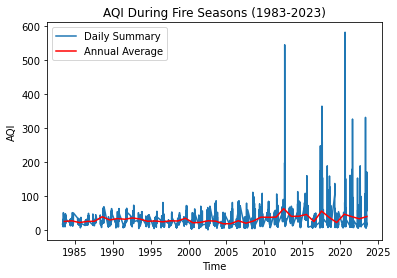

In [241]:
fig = plt.figure()
ax = fig.gca()
# plot daily
ax.plot(final_daily_estimate['date_local'], final_daily_estimate['aqi'], label = 'Daily Summary')
# plot annual
ax.plot(
    # convert year to a day in the middle of the fire season
    pd.to_datetime(final_annual_estimate['year'], format = '%Y') + pd.DateOffset(months=7)
    , final_annual_estimate['aqi'], color ='red', label='Annual Average')
plt.xlabel("Time")
plt.ylabel("AQI")
plt.title("AQI During Fire Seasons (1983-2023)")
plt.legend()

In [243]:
gas_df

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,41,017,0002,42101,1,44.059561,-121.325310,WGS84,Carbon monoxide,1,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,BILL TAYLOR REALTY/934 NE 3RD,Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2021-11-09
1,41,017,0002,42101,1,44.059561,-121.325310,WGS84,Carbon monoxide,1,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,BILL TAYLOR REALTY/934 NE 3RD,Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2021-11-09
2,41,017,0002,42101,1,44.059561,-121.325310,WGS84,Carbon monoxide,1,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,BILL TAYLOR REALTY/934 NE 3RD,Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2021-11-09
3,41,017,0002,42101,1,44.059561,-121.325310,WGS84,Carbon monoxide,1,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,BILL TAYLOR REALTY/934 NE 3RD,Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2021-11-09
4,41,017,0002,42101,1,44.059561,-121.325310,WGS84,Carbon monoxide,1,...,011,INSTRUMENTAL - NONDISPERSIVE INFRARED,None,BILL TAYLOR REALTY/934 NE 3RD,Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2021-11-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5264,41,017,0122,44201,1,44.021896,-121.260166,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Bend Deschutes County Road Department (BRD),Bend Deschutes County Road Department (BRD),Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2023-02-05
5265,41,017,0122,44201,1,44.021896,-121.260166,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Bend Deschutes County Road Department (BRD),Bend Deschutes County Road Department (BRD),Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2023-02-05
5266,41,017,0122,44201,1,44.021896,-121.260166,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Bend Deschutes County Road Department (BRD),Bend Deschutes County Road Department (BRD),Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2023-02-05
5267,41,017,0122,44201,1,44.021896,-121.260166,WGS84,Ozone,W,...,087,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,Bend Deschutes County Road Department (BRD),Bend Deschutes County Road Department (BRD),Oregon,Deschutes,Bend,13460,"Bend-Redmond, OR",2023-02-05
